In [0]:
#加载google drive上的数据集
!echo 'Installing required software'
!apt-get install -y -qq software-properties-common module-init-tools 2>&1 > /dev/null
!echo 'Add apt-repository with Google.Drive Fuse'
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!echo 'Updating packages...'
!apt-get update -y -qq
!echo 'Installing google-drive-ocamlfuse fuse...'
!apt-get install -y -qq google-drive-ocamlfuse fuse
!echo 'Authenticate Fuse in Google.Drive...'
from google.colab import auth
from oauth2client.client import GoogleCredentials
import getpass
auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass('Enter auth code here: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!echo 'Authenticated!'
!echo 'Creating mount directory'
!mkdir ./drive2
!echo 'Mounting...'
!google-drive-ocamlfuse ./drive2
!ls ./drive2
!echo 'Mounted!'

Installing required software
Add apt-repository with Google.Drive Fuse
Updating packages...
Installing google-drive-ocamlfuse fuse...
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Authenticate Fuse in Google.Drive...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Enter auth code here: ··········
Please, open the following URL in a web browser: https://accounts.googl

In [0]:
!ls

adc.json  drive2  sample_data


In [0]:
#解压数据集
!unzip -o ./drive2/Colab\ Notebooks/hy_round1_train_20200102.zip 
!unzip -o ./drive2/Colab\ Notebooks/hy_round1_testA_20200102.zip 

Streaming output truncated to the last 5000 lines.
  inflating: hy_round1_train_20200102/6117.csv  
  inflating: hy_round1_train_20200102/1829.csv  
  inflating: hy_round1_train_20200102/4192.csv  
  inflating: hy_round1_train_20200102/4623.csv  
  inflating: hy_round1_train_20200102/6525.csv  
  inflating: hy_round1_train_20200102/5047.csv  
  inflating: hy_round1_train_20200102/4943.csv  
  inflating: hy_round1_train_20200102/6281.csv  
  inflating: hy_round1_train_20200102/2658.csv  
  inflating: hy_round1_train_20200102/4339.csv  
  inflating: hy_round1_train_20200102/3892.csv  
  inflating: hy_round1_train_20200102/2646.csv  
  inflating: hy_round1_train_20200102/5650.csv  
  inflating: hy_round1_train_20200102/5238.csv  
  inflating: hy_round1_train_20200102/6587.csv  
  inflating: hy_round1_train_20200102/3243.csv  
  inflating: hy_round1_train_20200102/496.csv  
  inflating: hy_round1_train_20200102/1237.csv  
  inflating: hy_round1_train_20200102/2366.csv  
  inflating: hy_rou

In [0]:
!pip install hypertools

     |████████████████████████████████| 6.7MB 6.2MB/s 
  Created wheel for hypertools: filename=hypertools-0.6.2-cp36-none-any.whl size=46622 sha256=50c28e07f6457c9c856bb0dba6b3562d806f8dd8fcfd58a76d998bf65239b533
  Stored in directory: /root/.cache/pip/wheels/53/31/3a/0a3f26ae77857ae19ee5947fd2ee9bf34249fcd9c6c90636c2
Successfully built hypertools
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [0]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer 
import numpy as np
import math
import random

In [0]:
def haversine_array(lat1, lng1, lat2, lng2):
     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
     AVG_EARTH_RADIUS = 6371 # in km
     lat = lat2 - lat1
     lng = lng2 - lng1
     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
     return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
     a = haversine_array(lat1, lng1, lat1, lng2)
     b = haversine_array(lat1, lng1, lat2, lng1)
     return a + b

def bearing_array(lat1, lng1, lat2, lng2):
     AVG_EARTH_RADIUS = 6371 # in km
     lng_delta_rad = np.radians(lng2 - lng1)
     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
     y = np.sin(lng_delta_rad) * np.cos(lat2)
     x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
     return np.degrees(np.arctan2(y, x))

In [0]:
#构造统计特征
def preprocessing(data,id,start):
  data_proced = data[start:start+40]
  def stat_feature(data_):
    result_ = {}
    for feature in data_.columns:
      if(feature in {'渔船ID','time','type','time_convert','date','month'}):
        continue
      data_min = data_[feature].min()
      data_max = data_[feature].max()
      data_mean = data_[feature].mean()
      data_std = data_[feature].std()
      data_skew = data_[feature].skew()
      data_kurt = data_[feature].kurt()
      #均方根？？
      data_rms=math.sqrt(pow(data_mean,2) + pow(data_std,2))
      #波形因子
      data_boxing=data_rms / ((abs(data_[feature]).mean())+0.0001)
      #峰值因子
      data_fengzhi=(max(data_[feature])) / (data_rms+0.00001)
      #脉冲因子
      data_maichong=(max(data_[feature])) / ((abs(data_[feature]).mean())+0.00001)
      #裕度因子
      data_yudu=(max(data_[feature])) / (pow((data_[feature].map(lambda x: math.sqrt(abs(x))).sum()/(len(data_))),2)+0.00001)
      data_range = data_max - data_min
      data_covar = data_std/(data_mean+0.0001)
      result__ = {feature+'_min': data_min,feature+'_max': data_max,feature+'_mean':data_mean,
                feature+'_std':data_std,feature+'_skew':data_skew,feature+'_kurt':data_kurt,
                  feature+'_range':data_range,feature+'_covar':data_covar,feature+'_rms':data_rms,feature+'_boxing':data_boxing,
                  feature+'_fengzhi':data_fengzhi,
                  feature+'_maichong':data_maichong,feature+'_yudu':data_yudu}
      result_.update(result__)
    return result_
  #坐标x的变化
  data_proced['x_var'] = data_proced['x'] - data_proced['x'].shift(-1)
  #坐标y的变化
  data_proced['y_var'] = data_proced['y'] - data_proced['y'].shift(-1)
  #距离的变化
  data_proced['distance_var'] = (data_proced['x_var']*data_proced['x_var'] + data_proced['y_var']*data_proced['y_var']).apply(np.sqrt)
  #速度的变化
  data_proced['velocity_var'] = data_proced['速度'] - data_proced['速度'].shift(-1)
  #角度的变化
  data_proced['angle_var'] = data_proced['方向'] - data_proced['方向'].shift(-1)
  #日期转换成时间戳，没有年好像全给1970了 不过不使用年 应该没有关系
  data_proced['time_convert'] = [datetime.strptime(i, '%m%d %H:%M:%S') for i in data_proced['time']]
  #相邻记录的时间差
  data_proced['time_convert_var'] =data_proced['time_convert'] - data_proced['time_convert'].shift(-1)
  #时间差转换成秒
  data_proced['time_convert_var'] = [i.seconds for i in data_proced['time_convert_var']]
  # 距离的变化率，其实也就是速度
  data_proced['distance_c_rate'] = data_proced['distance_var']/data_proced['time_convert_var']
  #速度变化率，不一定沿直线走的，暂时就当它直线走的了，看作是加速度
  data_proced['velocity_c_rate'] = data_proced['velocity_var']/data_proced['time_convert_var']
  #角度变化率
  data_proced['angle_c_rate'] = data_proced['angle_var']/data_proced['time_convert_var']
  #计算出来的角度
  data_proced['computed_angle'] = np.arctan(data_proced['y_var']/(data_proced['x_var']+0.00001))
  data_proced['computed_angle_c_rate'] = data_proced['computed_angle']/(data_proced['time_convert_var']+0.00001)

  data_proced['haversine'] = haversine_array(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data_proced['y'])
  data_proced['dummy_manhattan_distance'] = dummy_manhattan_distance(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data_proced['y'])
  data_proced['bearing'] = bearing_array(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data_proced['y'])
  data_proced.dropna(inplace=True)
  result = stat_feature(data_proced)
  for i in [0.25,0.75]:
    result['x_quantile_'+str(i)] = data_proced['x'].quantile(i)
    result['y_quantile_'+str(i)] = data_proced['y'].quantile(i)
    result['速度_quantile_'+str(i)] = data_proced['速度'].quantile(i)
    result['速度_quantile_'+str(i)] = data_proced['速度'].quantile(i)
    result['distance_var_quantile_'+str(i)] = data_proced['distance_var'].quantile(i)
    result['velocity_var_quantile_'+str(i)] = data_proced['velocity_var'].quantile(i)
    result['angle_var_quantile_'+str(i)] = data_proced['angle_var'].quantile(i)
    result['time_convert_var_quantile_'+str(i)] = data_proced['time_convert_var'].quantile(i)
    result['distance_c_rate_quantile_'+str(i)] = data_proced['distance_c_rate'].quantile(i)
    result['velocity_c_rate_quantile_'+str(i)] = data_proced['velocity_c_rate'].quantile(i)

  result['xy_cov'] = data_proced['x'].cov(data['y'])
  result['max_area'] = (result['x_max'] - result['x_min'])*(result['y_max']-result['y_min'])
  #速度最多的值
  result['velocity_first_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,51)).value_counts().index[0].left
  #速度第二多的值
  result['velocity_second_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,51)).value_counts().index[1].left
  #速度第三多的值
  result['velocity_third_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,51)).value_counts().index[2].left
  result['id'] = id
  result['type'] = data['type'][0]
  return result

In [0]:
#读取数据集，记录不合并
def read_data(data_dir_pre):
  data_dir = os.listdir(data_dir_pre)
  #读取文件
  data = {}
  proced_data = []
  count = 0
  for filename in data_dir:
    count = count + 1
    if(count%10==0):
      print('正在读取第{}个文件'.format(count))
    data[filename.split('.',1)[0]] = pd.read_csv(data_dir_pre + filename)
  #预处理数据
  count = 0
  seed = 0
  for i in data.keys():
    count = count+1
    if(count%10==0):
      print('正在为数据的第{}个文件构造数据的特征'.format(count))
    #数据增广，40个数据一组 ，采样3次得到特征
    data_len = len(data[i])
    if(data_len<50):
        continue
    data_len = data_len - 40
    for j in range(10):
      random.seed(seed)
      start = random.randint(0,data_len)
      seed = start #更新随机数种子
      proc_ = preprocessing(data[i],i,start)
      proced_data.append(proc_)
  return proced_data

In [0]:
#读取数据集，记录不合并
def read_test(data_dir_pre):
  #构造统计特征
  def preprocessing_(data,id,start):
    data_proced = data[start:(start+40)]
    def stat_feature(data_):
      result_ = {}
      for feature in data_.columns:
        #print(feature)
        if(feature in {'渔船ID','time','type','time_convert','date','month'}):
          continue
        data_min = data_[feature].min()
        data_max = data_[feature].max()
        data_mean = data_[feature].mean()
        data_std = data_[feature].std()
        data_skew = data_[feature].skew()
        data_kurt = data_[feature].kurt()
        #均方根？？
        data_rms=math.sqrt(pow(data_mean,2) + pow(data_std,2))
        #波形因子
        data_boxing=data_rms / ((abs(data_[feature]).mean())+0.0001)
        #峰值因子
        data_fengzhi=(max(data_[feature])) / (data_rms+0.00001)
        #脉冲因子
        data_maichong=(max(data_[feature])) / ((abs(data_[feature]).mean())+0.00001)
        #裕度因子
        data_yudu=(max(data_[feature])) / (pow((data_[feature].map(lambda x: math.sqrt(abs(x))).sum()/(len(data_))),2)+0.00001)
        data_range = data_max - data_min
        data_covar = data_std/(data_mean+0.0001)

        result__ = {feature+'_min':data_min,feature+'_max':data_max,feature+'_mean':data_mean,
                feature+'_std':data_std,feature+'_skew':data_skew,feature+'_kurt':data_kurt,
                  feature+'_range':data_range,feature+'_covar':data_covar,feature+'_rms':data_rms,feature+'_boxing':data_boxing,feature+'_fengzhi':data_fengzhi,
                  feature+'_maichong':data_maichong,feature+'_yudu':data_yudu}
        result_.update(result__)
      return result_
    #坐标x的变化
    data_proced['x_var'] = data_proced['x'] - data_proced['x'].shift(-1)
    #坐标y的变化
    data_proced['y_var'] = data_proced['y'] - data_proced['y'].shift(-1)

    #距离的变化
    data_proced['distance_var'] = (data_proced['x_var']*data_proced['x_var'] + data_proced['y_var']*data_proced['y_var']).apply(np.sqrt)
    #速度的变化
    data_proced['velocity_var'] = data_proced['速度'] - data_proced['速度'].shift(-1)
    #角度的变化
    data_proced['angle_var'] = data_proced['方向'] -data_proced['方向'].shift(-1)
    #日期转换成时间戳，没有年好像全给1970了 不过不使用年 应该没有关系
    data_proced['time_convert'] = [datetime.strptime(i, '%m%d %H:%M:%S') for i in data_proced['time']]
    #相邻记录的时间差
    data_proced['time_convert_var'] =data_proced['time_convert'] - data_proced['time_convert'].shift(-1)
    #时间差转换成秒
    data_proced['time_convert_var'] = [i.seconds for i in data_proced['time_convert_var']]
    # 距离的变化率，其实也就是速度
    data_proced['distance_c_rate'] = data_proced['distance_var']/data_proced['time_convert_var']
    #速度变化率，不一定沿直线走的，暂时就当它直线走的了，看作是加速度
    data_proced['velocity_c_rate'] = data_proced['velocity_var']/data_proced['time_convert_var']
    #角度变化率
    data_proced['angle_c_rate'] = data_proced['angle_var']/data_proced['time_convert_var']
    #计算出来的角度
    data_proced['computed_angle'] = np.arctan(data_proced['y_var']/(data_proced['x_var']+0.00001))
    data_proced['computed_angle_c_rate'] = data_proced['computed_angle']/(data_proced['time_convert_var']+0.00001)

    data_proced['haversine'] = haversine_array(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data_proced['y'])
    data_proced['dummy_manhattan_distance'] = dummy_manhattan_distance(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data_proced['y'])
    data_proced['bearing'] = bearing_array(data_proced['x'].shift(-1),data_proced['y'].shift(-1),data_proced['x'],data['y'])
    data_proced.dropna(inplace=True)
    result = stat_feature(data_proced)
    for i in [0.25,0.75]:
      result['x_quantile_'+str(i)] = data_proced['x'].quantile(i)
      result['y_quantile_'+str(i)] = data_proced['y'].quantile(i)
      result['速度_quantile_'+str(i)] = data_proced['速度'].quantile(i)
      result['速度_quantile_'+str(i)] = data_proced['速度'].quantile(i)
      result['distance_var_quantile_'+str(i)] = data_proced['distance_var'].quantile(i)
      result['velocity_var_quantile_'+str(i)] = data_proced['velocity_var'].quantile(i)
      result['angle_var_quantile_'+str(i)] = data_proced['angle_var'].quantile(i)
      result['time_convert_var_quantile_'+str(i)] = data_proced['time_convert_var'].quantile(i)
      result['distance_c_rate_quantile_'+str(i)] = data_proced['distance_c_rate'].quantile(i)
      result['velocity_c_rate_quantile_'+str(i)] = data_proced['velocity_c_rate'].quantile(i)
      result['angle_c_rate_quantile_'+str(i)] = data_proced['angle_c_rate'].quantile(i)
      result['haversine_'+str(i)] = data_proced['haversine'].quantile(i)
      result['dummy_manhattan_distance_'+str(i)] = data_proced['dummy_manhattan_distance'].quantile(i)
      result['bearing_'+str(i)] = data_proced['bearing'].quantile(i)
    result['xy_cov'] = data_proced['x'].cov(data_proced['y'])
    result['max_area'] = (result['x_max'] - result['x_min'])*(result['y_max']-result['y_min'])
    #速度最多的值
    result['velocity_first_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,101)).value_counts().index[0].left
    #速度第二多的值
    result['velocity_second_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,101)).value_counts().index[1].left
    #速度第三多的值
    result['velocity_third_counts'] = pd.cut(data_proced['速度'],np.linspace(0,50,101)).value_counts().index[2].left
    result['id'] = id
    return result
  data_dir = os.listdir(data_dir_pre)
  #读取文件
  data = {}
  proced_data = []
  count = 0
  for filename in data_dir:
    count = count + 1
    if(count%10==0):
      print('正在读取第{}个文件'.format(count))
    data[filename.split('.',1)[0]] = pd.read_csv(data_dir_pre + filename)
  #预处理数据
  count = 0
  seed = 0
  for i in data.keys():
    count = count+1
    if(count%10==0):
      print('正在为数据的第{}个文件构造数据的特征'.format(count))
    #数据增广，40个数据一组 ，采样3次得到特征
    data_len = len(data[i])
    if(data_len<50):
        continue
    data_len = data_len - 40
    for j in range(10):
      random.seed(seed)
      start = random.randint(0,data_len)
      seed = start #更新随机数种子
      proc_ = preprocessing_(data[i],i,start)
      proced_data.append(proc_)
  return proced_data

In [0]:
#获取训练数据集
train_ = read_data('hy_round1_train_20200102/')

正在读取第10个文件
正在读取第20个文件
正在读取第30个文件
正在读取第40个文件
正在读取第50个文件
正在读取第60个文件
正在读取第70个文件
正在读取第80个文件
正在读取第90个文件
正在读取第100个文件
正在读取第110个文件
正在读取第120个文件
正在读取第130个文件
正在读取第140个文件
正在读取第150个文件
正在读取第160个文件
正在读取第170个文件
正在读取第180个文件
正在读取第190个文件
正在读取第200个文件
正在读取第210个文件
正在读取第220个文件
正在读取第230个文件
正在读取第240个文件
正在读取第250个文件
正在读取第260个文件
正在读取第270个文件
正在读取第280个文件
正在读取第290个文件
正在读取第300个文件
正在读取第310个文件
正在读取第320个文件
正在读取第330个文件
正在读取第340个文件
正在读取第350个文件
正在读取第360个文件
正在读取第370个文件
正在读取第380个文件
正在读取第390个文件
正在读取第400个文件
正在读取第410个文件
正在读取第420个文件
正在读取第430个文件
正在读取第440个文件
正在读取第450个文件
正在读取第460个文件
正在读取第470个文件
正在读取第480个文件
正在读取第490个文件
正在读取第500个文件
正在读取第510个文件
正在读取第520个文件
正在读取第530个文件
正在读取第540个文件
正在读取第550个文件
正在读取第560个文件
正在读取第570个文件
正在读取第580个文件
正在读取第590个文件
正在读取第600个文件
正在读取第610个文件
正在读取第620个文件
正在读取第630个文件
正在读取第640个文件
正在读取第650个文件
正在读取第660个文件
正在读取第670个文件
正在读取第680个文件
正在读取第690个文件
正在读取第700个文件
正在读取第710个文件
正在读取第720个文件
正在读取第730个文件
正在读取第740个文件
正在读取第750个文件
正在读取第760个文件
正在读取第770个文件
正在读取第780个文件
正在读取第790个文件
正在读取第800个文件
正在读取第810个文件
正在读取第820个文件
正在读取第830个文件
正在读取第840个文件
正

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

正在为数据的第10个文件构造数据的特征
正在为数据的第20个文件构造数据的特征
正在为数据的第30个文件构造数据的特征
正在为数据的第40个文件构造数据的特征
正在为数据的第50个文件构造数据的特征
正在为数据的第60个文件构造数据的特征
正在为数据的第70个文件构造数据的特征
正在为数据的第80个文件构造数据的特征
正在为数据的第90个文件构造数据的特征
正在为数据的第100个文件构造数据的特征
正在为数据的第110个文件构造数据的特征
正在为数据的第120个文件构造数据的特征
正在为数据的第130个文件构造数据的特征
正在为数据的第140个文件构造数据的特征
正在为数据的第150个文件构造数据的特征
正在为数据的第160个文件构造数据的特征
正在为数据的第170个文件构造数据的特征
正在为数据的第180个文件构造数据的特征
正在为数据的第190个文件构造数据的特征
正在为数据的第200个文件构造数据的特征
正在为数据的第210个文件构造数据的特征
正在为数据的第220个文件构造数据的特征
正在为数据的第230个文件构造数据的特征
正在为数据的第240个文件构造数据的特征
正在为数据的第250个文件构造数据的特征
正在为数据的第260个文件构造数据的特征
正在为数据的第270个文件构造数据的特征
正在为数据的第280个文件构造数据的特征
正在为数据的第290个文件构造数据的特征
正在为数据的第300个文件构造数据的特征
正在为数据的第310个文件构造数据的特征
正在为数据的第320个文件构造数据的特征
正在为数据的第330个文件构造数据的特征
正在为数据的第340个文件构造数据的特征
正在为数据的第350个文件构造数据的特征
正在为数据的第360个文件构造数据的特征
正在为数据的第370个文件构造数据的特征
正在为数据的第380个文件构造数据的特征
正在为数据的第390个文件构造数据的特征
正在为数据的第400个文件构造数据的特征
正在为数据的第410个文件构造数据的特征
正在为数据的第420个文件构造数据的特征
正在为数据的第430个文件构造数据的特征
正在为数据的第440个文件构造数据的特征
正在为数据的第450个文件构造数据的特征
正在为数据的第460个文件构造数据的特征
正在为数据的第470个文件构造数据的特征
正在为数据的第480个文件构造数据的特征
正

In [0]:
import pickle

In [0]:
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
train_file = open('drive2/Colab Notebooks/train.pkl','wb')
pickle.dump(train_, train_file)
train_file.close()

In [0]:
train_file = open('drive2/Colab Notebooks/train.pkl','rb')
train_ = pickle.load(train_file)
train_file.close()

In [0]:
test_ = read_test('hy_round1_testA_20200102/')

正在读取第10个文件
正在读取第20个文件
正在读取第30个文件
正在读取第40个文件
正在读取第50个文件
正在读取第60个文件
正在读取第70个文件
正在读取第80个文件
正在读取第90个文件
正在读取第100个文件
正在读取第110个文件
正在读取第120个文件
正在读取第130个文件
正在读取第140个文件
正在读取第150个文件
正在读取第160个文件
正在读取第170个文件
正在读取第180个文件
正在读取第190个文件
正在读取第200个文件
正在读取第210个文件
正在读取第220个文件
正在读取第230个文件
正在读取第240个文件
正在读取第250个文件
正在读取第260个文件
正在读取第270个文件
正在读取第280个文件
正在读取第290个文件
正在读取第300个文件
正在读取第310个文件
正在读取第320个文件
正在读取第330个文件
正在读取第340个文件
正在读取第350个文件
正在读取第360个文件
正在读取第370个文件
正在读取第380个文件
正在读取第390个文件
正在读取第400个文件
正在读取第410个文件
正在读取第420个文件
正在读取第430个文件
正在读取第440个文件
正在读取第450个文件
正在读取第460个文件
正在读取第470个文件
正在读取第480个文件
正在读取第490个文件
正在读取第500个文件
正在读取第510个文件
正在读取第520个文件
正在读取第530个文件
正在读取第540个文件
正在读取第550个文件
正在读取第560个文件
正在读取第570个文件
正在读取第580个文件
正在读取第590个文件
正在读取第600个文件
正在读取第610个文件
正在读取第620个文件
正在读取第630个文件
正在读取第640个文件
正在读取第650个文件
正在读取第660个文件
正在读取第670个文件
正在读取第680个文件
正在读取第690个文件
正在读取第700个文件
正在读取第710个文件
正在读取第720个文件
正在读取第730个文件
正在读取第740个文件
正在读取第750个文件
正在读取第760个文件
正在读取第770个文件
正在读取第780个文件
正在读取第790个文件
正在读取第800个文件
正在读取第810个文件
正在读取第820个文件
正在读取第830个文件
正在读取第840个文件
正

In [0]:
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
#!!!!慎点 慎点 慎点，以免储存处理好的数据炸掉
test_file = open('drive2/Colab Notebooks/test.pkl','wb')
pickle.dump(test_, test_file)
test_file.close()

In [0]:
test_file = open('drive2/Colab Notebooks/test.pkl','rb')
test_ = pickle.load(test_file)
test_file.close()

In [0]:
train = pd.DataFrame.from_dict(train_)
train.set_index(['id'],inplace=True)


In [0]:
test_x = pd.DataFrame.from_dict(test_)
test_x.set_index(['id'],inplace=True)

In [0]:
#test_x

In [0]:
train_x = train
train_y = train.pop('type')

In [0]:
train_x[train_x['x_std']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
816,6.392909e+06,6.392909e+06,6.392909e+06,0.0,0.0,0.0,0.0,0.0,6.392909e+06,1.0,1.0,1.0,1.0,5.475101e+06,5.475101e+06,5.475101e+06,4.569958e-08,0.0,0.0,0.0,8.346801e-15,5.475101e+06,1.0,1.0,1.0,1.0,0.0,0.38,0.058272,0.065271,1.674737,3.004151,0.38,1.118198,0.087498,1.498981,4.342438,6.520028,10.548229,0,...,0.05,0.00,600.0,0.0,0.000083,0.000000,0.0,0.0,0.0,6.392909e+06,5.475101e+06,0.16,0.0,0.05,0.00,601.0,0.0,0.000084,0.000000,0.0,0.0,0.0,6.392909e+06,5.475101e+06,0.16,0.0,0.11,0.0,601.0,0.0,0.000183,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,18.0,13.0
3882,6.131056e+06,6.131056e+06,6.131056e+06,0.0,0.0,0.0,0.0,0.0,6.131056e+06,1.0,1.0,1.0,1.0,5.135928e+06,5.135928e+06,5.135928e+06,9.325067e-10,0.0,0.0,0.0,1.815654e-16,5.135928e+06,1.0,1.0,1.0,1.0,0.0,10.09,0.250279,0.784019,9.599359,101.760930,10.09,3.131328,0.822998,3.287007,12.259904,40.313367,72.422649,0,...,0.11,90.82,603.0,0.0,0.000178,0.134688,0.0,0.0,-0.0,6.131056e+06,5.135928e+06,0.32,0.0,0.11,150.26,608.0,0.0,0.000184,0.219459,0.0,0.0,-0.0,6.131056e+06,5.135928e+06,0.32,0.0,0.22,204.8,1169.3,0.0,0.000362,0.313098,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,3.5


In [0]:
train_x[train_x['y_std']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3615,6.374567e+06,6.374567e+06,6.374567e+06,2.523109e-08,0.0,0.0,0.0,3.958088e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.472986e+06,0.0,0.0,0.0,0.0,0.0,5.472986e+06,1.0,1.0,1.0,1.0,2.38,2.38,2.38,3.119180e-15,0.0,0.0,0.0,1.310525e-15,2.38,0.999958,0.999996,0.999996,0.999996,360,...,0.0,0.0,1806.00,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1807.0,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1808.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.5,18.5
2302,6.374567e+06,6.374567e+06,6.374567e+06,2.336490e-08,0.0,0.0,0.0,3.665332e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.472986e+06,0.0,0.0,0.0,0.0,0.0,5.472986e+06,1.0,1.0,1.0,1.0,2.38,2.38,2.38,3.119551e-15,0.0,0.0,0.0,1.310681e-15,2.38,0.999958,0.999996,0.999996,0.999996,360,...,0.0,0.0,1806.00,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1807.0,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1808.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.5,18.5
6228,6.374567e+06,6.374567e+06,6.374567e+06,2.336667e-08,0.0,0.0,0.0,3.665608e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.472986e+06,0.0,0.0,0.0,0.0,0.0,5.472986e+06,1.0,1.0,1.0,1.0,2.38,2.38,2.38,3.119787e-15,0.0,0.0,0.0,1.310780e-15,2.38,0.999958,0.999996,0.999996,0.999996,360,...,0.0,0.0,1805.00,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1806.0,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1808.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.5,18.5
6535,6.374567e+06,6.374567e+06,6.374567e+06,2.336607e-08,0.0,0.0,0.0,3.665515e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.472986e+06,0.0,0.0,0.0,0.0,0.0,5.472986e+06,1.0,1.0,1.0,1.0,2.38,2.38,2.38,3.119707e-15,0.0,0.0,0.0,1.310746e-15,2.38,0.999958,0.999996,0.999996,0.999996,360,...,0.0,0.0,1806.00,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1807.0,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.5,18.5
4363,6.374567e+06,6.374567e+06,6.374567e+06,2.429717e-08,0.0,0.0,0.0,3.811580e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.472986e+06,0.0,0.0,0.0,0.0,0.0,5.472986e+06,1.0,1.0,1.0,1.0,2.38,2.38,2.38,3.119252e-15,0.0,0.0,0.0,1.310555e-15,2.38,0.999958,0.999996,0.999996,0.999996,360,...,0.0,0.0,1805.04,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1806.0,0.0,0.0,0.0,0.0,0.0,0.0,6.374567e+06,5.472986e+06,2.38,0.0,0.0,0.0,1808.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.5,18.5
2867,6.374567e+06,6.374567e+06,6.374567e+06,2.522995e-08,0.0,0.0,0.0,3.957908e-15,6.374567e+06,1.0,1.0,1.0,1.0,5.472986e+06,5.472986e+06,5.

In [0]:
train_x[train_x['y_range']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3707,6.102649e+06,6.102649e+06,6.102649e+06,1.212232e-08,0.0,0.0,0.0,1.986402e-15,6.102649e+06,1.0,1.0,1.0,1.0,5.112536e+06,5.112536e+06,5.112536e+06,4.382684e-08,0.0,0.0,0.0,8.572426e-15,5.112536e+06,1.0,1.0,1.0,1.0,0.00,0.16,0.011820,2.912778e-02,3.295825,12.791720,0.16,2.443514e+00,0.031435,2.637054,5.088271,13.524423,75.978109,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.05,0.0,657.0,0.0,0.000083,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,18.0,13.0
3041,6.297438e+06,6.297438e+06,6.297438e+06,4.662261e-08,0.0,0.0,0.0,7.403424e-15,6.297438e+06,1.0,1.0,1.0,1.0,5.284451e+06,5.284451e+06,5.284451e+06,2.797356e-08,0.0,0.0,0.0,5.293561e-15,5.284451e+06,1.0,1.0,1.0,1.0,0.00,0.76,0.025884,7.239325e-02,5.413658,38.781304,0.76,2.786094e+00,0.076881,2.958824,9.884068,29.350681,137.644701,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.0,0.05,0.0,656.8,0.0,0.000083,0.0,0.0,0.0,0.0,-8.694670e-19,0.0,0.0,0.5,18.5
4027,6.118455e+06,6.118455e+06,6.118455e+06,1.864915e-09,0.0,0.0,0.0,3.048016e-16,6.118455e+06,1.0,1.0,1.0,1.0,5.130779e+06,5.130779e+06,5.130779e+06,2.517636e-08,0.0,0.0,0.0,4.906927e-15,5.130779e+06,1.0,1.0,1.0,1.0,0.00,0.38,0.006934,3.290553e-02,7.731686,69.578464,0.38,4.677864e+00,0.033628,4.780604,11.296668,54.721086,730.490667,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,657.0,0.0,0.000000,0.0,0.0,0.0,-0.0,0.000000e+00,0.0,0.0,18.0,13.0
3214,6.109209e+06,6.109209e+06,6.109209e+06,3.729864e-09,0.0,0.0,0.0,6.105314e-16,6.109209e+06,1.0,1.0,1.0,1.0,5.114764e+06,5.114764e+06,5.114764e+06,3.263631e-08,0.0,0.0,0.0,6.380805e-15,5.114764e+06,1.0,1.0,1.0,1.0,0.00,0.38,0.014044,3.614152e-02,4.879495,34.971968,0.38,2.555233e+00,0.038774,2.741373,9.797778,27.038339,138.525295,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.05,0.0,657.0,0.0,0.000083,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,18.0,13.0
6593,6.109105e+06,6.109105e+06,6.109105e+06,1.118959e-08,0.0,0.0,0.0,1.831625e-15,6.109105e+06,1.0,1.0,1.0,1.0,5.114657e+06,5.114657e+06,5.114657e+06,3.916357e-08,0.0,0.0,0.0,7.657125e-15,5.114657e+06,1.0,1.0,1.0,1.0,0.00,2.97,0.068824,1.893402e-01,10.228706,141.669833,2.97,2.747106e+00,0.201461,2.922959,14.741601,43.147577,107.784550,0,...,0.05,0.0,600.00,0.0,0.000083,0.0,0.0,0.0,-0.0,6.

In [0]:
train_x[train_x['x_range']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3707,6.102649e+06,6.102649e+06,6.102649e+06,1.212232e-08,0.0,0.0,0.0,1.986402e-15,6.102649e+06,1.0,1.0,1.0,1.0,5.112536e+06,5.112536e+06,5.112536e+06,4.382684e-08,0.0,0.0,0.0,8.572426e-15,5.112536e+06,1.0,1.0,1.0,1.0,0.00,0.16,0.011820,2.912778e-02,3.295825,12.791720,0.16,2.443514e+00,0.031435,2.637054,5.088271,13.524423,75.978109,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.05,0.0,657.0,0.0,0.000083,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,18.0,13.0
3041,6.297438e+06,6.297438e+06,6.297438e+06,4.662261e-08,0.0,0.0,0.0,7.403424e-15,6.297438e+06,1.0,1.0,1.0,1.0,5.284451e+06,5.284451e+06,5.284451e+06,2.797356e-08,0.0,0.0,0.0,5.293561e-15,5.284451e+06,1.0,1.0,1.0,1.0,0.00,0.76,0.025884,7.239325e-02,5.413658,38.781304,0.76,2.786094e+00,0.076881,2.958824,9.884068,29.350681,137.644701,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.0,0.05,0.0,656.8,0.0,0.000083,0.0,0.0,0.0,0.0,-8.694670e-19,0.0,0.0,0.5,18.5
4027,6.118455e+06,6.118455e+06,6.118455e+06,1.864915e-09,0.0,0.0,0.0,3.048016e-16,6.118455e+06,1.0,1.0,1.0,1.0,5.130779e+06,5.130779e+06,5.130779e+06,2.517636e-08,0.0,0.0,0.0,4.906927e-15,5.130779e+06,1.0,1.0,1.0,1.0,0.00,0.38,0.006934,3.290553e-02,7.731686,69.578464,0.38,4.677864e+00,0.033628,4.780604,11.296668,54.721086,730.490667,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,657.0,0.0,0.000000,0.0,0.0,0.0,-0.0,0.000000e+00,0.0,0.0,18.0,13.0
3214,6.109209e+06,6.109209e+06,6.109209e+06,3.729864e-09,0.0,0.0,0.0,6.105314e-16,6.109209e+06,1.0,1.0,1.0,1.0,5.114764e+06,5.114764e+06,5.114764e+06,3.263631e-08,0.0,0.0,0.0,6.380805e-15,5.114764e+06,1.0,1.0,1.0,1.0,0.00,0.38,0.014044,3.614152e-02,4.879495,34.971968,0.38,2.555233e+00,0.038774,2.741373,9.797778,27.038339,138.525295,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.05,0.0,657.0,0.0,0.000083,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,18.0,13.0
6593,6.109105e+06,6.109105e+06,6.109105e+06,1.118959e-08,0.0,0.0,0.0,1.831625e-15,6.109105e+06,1.0,1.0,1.0,1.0,5.114657e+06,5.114657e+06,5.114657e+06,3.916357e-08,0.0,0.0,0.0,7.657125e-15,5.114657e+06,1.0,1.0,1.0,1.0,0.00,2.97,0.068824,1.893402e-01,10.228706,141.669833,2.97,2.747106e+00,0.201461,2.922959,14.741601,43.147577,107.784550,0,...,0.05,0.0,600.00,0.0,0.000083,0.0,0.0,0.0,-0.0,6.

In [0]:
train_x[train_x['速度_std']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6605,6.165599e+06,6.165599e+06,6.165599e+06,3.749719e-09,0.0,0.0,0.0,6.081677e-16,6.165599e+06,1.0,1.0,1.0,1.0,5.202660e+06,5.202660e+06,5.202660e+06,5.624578e-09,0.0,0.0,0.0,1.081097e-15,5.202660e+06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360,...,0.0,0.0,1823.48,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1833.64,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1861.2,0.0,0.0,0.0,0.0,0.0,-0.0,1.757549e-18,0.0,49.5,18.0,13.0
1709,6.165599e+06,6.165599e+06,6.165599e+06,2.812783e-09,0.0,0.0,0.0,4.562059e-16,6.165599e+06,1.0,1.0,1.0,1.0,5.202660e+06,5.202660e+06,5.202660e+06,4.687971e-09,0.0,0.0,0.0,9.010719e-16,5.202660e+06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360,...,0.0,0.0,1845.76,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1909.68,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,4653.4,0.0,0.0,0.0,0.0,0.0,-0.0,1.758166e-18,0.0,49.5,18.0,13.0
3423,6.165599e+06,6.165599e+06,6.165599e+06,8.414838e-09,0.0,0.0,0.0,1.364805e-15,6.165599e+06,1.0,1.0,1.0,1.0,5.202660e+06,5.202660e+06,5.202660e+06,1.121978e-08,0.0,0.0,0.0,2.156548e-15,5.202660e+06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360,...,0.0,0.0,1815.00,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1822.14,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1833.6,0.0,0.0,0.0,0.0,0.0,-0.0,8.741914e-19,0.0,49.5,18.0,13.0
6791,6.165599e+06,6.165599e+06,6.165599e+06,6.549370e-09,0.0,0.0,0.0,1.062244e-15,6.165599e+06,1.0,1.0,1.0,1.0,5.202660e+06,5.202660e+06,5.202660e+06,9.356243e-09,0.0,0.0,0.0,1.798358e-15,5.202660e+06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360,...,0.0,0.0,1824.84,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1836.56,0.0,0.0,0.0,0.0,0.0,-0.0,6.165599e+06,5.202660e+06,0.0,0.0,0.0,0.0,1869.8,0.0,0.0,0.0,0.0,0.0,-0.0,1.750786e-18,0.0,49.5,18.0,13.0


In [0]:
train_x[train_x['方向_std']==0]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3707,6.102649e+06,6.102649e+06,6.102649e+06,1.212232e-08,0.000000,0.000000,0.000000,1.986402e-15,6.102649e+06,1.0,1.000000,1.000000,1.000000,5.112536e+06,5.112536e+06,5.112536e+06,4.382684e-08,0.000000,0.000000,0.000000,8.572426e-15,5.112536e+06,1.0,1.000000,1.000000,1.000000,0.00,0.16,0.011820,2.912778e-02,3.295825,12.791720,0.16,2.443514e+00,0.031435,2.637054,5.088271,13.524423,75.978109,0,...,0.0,0.0,600.00,0.0,0.0,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.000000,0.05,0.0,657.0,0.000000,0.000083,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,18.0,13.0
4027,6.118455e+06,6.118455e+06,6.118455e+06,1.864915e-09,0.000000,0.000000,0.000000,3.048016e-16,6.118455e+06,1.0,1.000000,1.000000,1.000000,5.130779e+06,5.130779e+06,5.130779e+06,2.517636e-08,0.000000,0.000000,0.000000,4.906927e-15,5.130779e+06,1.0,1.000000,1.000000,1.000000,0.00,0.38,0.006934,3.290553e-02,7.731686,69.578464,0.38,4.677864e+00,0.033628,4.780604,11.296668,54.721086,730.490667,0,...,0.0,0.0,600.00,0.0,0.0,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.000000,0.00,0.0,657.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.000000,0.000000e+00,0.000000,0.0,18.0,13.0
4205,6.165590e+06,6.165590e+06,6.165590e+06,6.540809e-09,0.000000,0.000000,0.000000,1.060857e-15,6.165590e+06,1.0,1.000000,1.000000,1.000000,5.202004e+06,5.202004e+06,5.202004e+06,1.027841e-08,0.000000,0.000000,0.000000,1.975857e-15,5.202004e+06,1.0,1.000000,1.000000,1.000000,0.11,0.11,0.110000,2.227786e-16,0.000000,0.000000,0.00,2.023421e-15,0.110000,0.999092,0.999909,0.999909,0.999909,360,...,0.0,0.0,1816.22,0.0,0.0,0.0,0.0,0.0,-0.0,6.165590e+06,5.202004e+06,0.11,0.0,0.00,0.0,1822.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.165590e+06,5.202004e+06,0.11,0.000000,0.00,0.0,1836.9,0.000000,0.000000,0.0,0.000000,0.000000,-0.000000,8.731059e-19,0.000000,0.0,18.0,13.0
2059,6.109209e+06,6.109211e+06,6.109209e+06,7.213759e-01,1.923869,1.709607,1.995929,1.180801e-07,6.109209e+06,1.0,1.000000,1.000000,1.000000,5.114764e+06,5.114873e+06,5.114781e+06,3.938596e+01,1.923869,1.709607,108.974491,7.700420e-06,5.114781e+06,1.0,1.000018,1.000018,1.000018,0.00,0.38,0.028900,5.291977e-02,3.149356,13.121695,0.38,1.824835e+00,0.060297,2.079216,6.301119,13.144352,38.362405,0,...,0.0,0.0,600.00,0.0,0.0,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.05,0.0,600.56,0.0,0.000083,0.0,0.0,0.0,0.0,6.109211e+06,5.114873e+06,0.05,0.000000,0.05,0.0,657.0,0.000000,0.000083,0.0,0.000000,0.000000,0.000000,2.841208e+01,217.505316,0.0,18.0,13.0
6605,6.165599e+06,6.165599e+06,6.165599e+06,3.74

In [0]:
train_x[(train_x['x_std']==0)|(train_x['y_std']==0)|(train_x['y_range']==0)|(train_x['y_range']==0)|(train_x['x_range']==0)|(train_x['速度_std']==0)|(train_x['方向_std']==0)]

,x_min,x_max,x_mean,x_std,x_skew,x_kurt,x_range,x_covar,x_rms,x_boxing,x_fengzhi,x_maichong,x_yudu,y_min,y_max,y_mean,y_std,y_skew,y_kurt,y_range,y_covar,y_rms,y_boxing,y_fengzhi,y_maichong,y_yudu,速度_min,速度_max,速度_mean,速度_std,速度_skew,速度_kurt,速度_range,速度_covar,速度_rms,速度_boxing,速度_fengzhi,速度_maichong,速度_yudu,方向_min,...,velocity_var_quantile_0.74,angle_var_quantile_0.74,time_convert_var_quantile_0.74,distance_c_rate_quantile_0.74,velocity_c_rate_quantile_0.74,angle_c_rate_quantile_0.74,haversine_0.74,dummy_manhattan_distance_0.74,bearing_0.74,x_quantile_0.82,y_quantile_0.82,速度_quantile_0.82,distance_var_quantile_0.82,velocity_var_quantile_0.82,angle_var_quantile_0.82,time_convert_var_quantile_0.82,distance_c_rate_quantile_0.82,velocity_c_rate_quantile_0.82,angle_c_rate_quantile_0.82,haversine_0.82,dummy_manhattan_distance_0.82,bearing_0.82,x_quantile_0.9,y_quantile_0.9,速度_quantile_0.9,distance_var_quantile_0.9,velocity_var_quantile_0.9,angle_var_quantile_0.9,time_convert_var_quantile_0.9,distance_c_rate_quantile_0.9,velocity_c_rate_quantile_0.9,angle_c_rate_quantile_0.9,haversine_0.9,dummy_manhattan_distance_0.9,bearing_0.9,xy_cov,max_area,velocity_first_counts,velocity_second_counts,velocity_third_counts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3707,6.102649e+06,6.102649e+06,6.102649e+06,1.212232e-08,0.000000,0.000000,0.000000,1.986402e-15,6.102649e+06,1.0,1.000000,1.000000,1.000000,5.112536e+06,5.112536e+06,5.112536e+06,4.382684e-08,0.000000,0.000000,0.000000,8.572426e-15,5.112536e+06,1.0,1.000000,1.000000,1.000000,0.00,0.16,0.011820,2.912778e-02,3.295825,12.791720,0.16,2.443514e+00,0.031435,2.637054,5.088271,13.524423,75.978109,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.102649e+06,5.112536e+06,0.05,0.000000,0.05,0.0,657.0,0.000000,0.000083,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,18.0,13.0
3041,6.297438e+06,6.297438e+06,6.297438e+06,4.662261e-08,0.000000,0.000000,0.000000,7.403424e-15,6.297438e+06,1.0,1.000000,1.000000,1.000000,5.284451e+06,5.284451e+06,5.284451e+06,2.797356e-08,0.000000,0.000000,0.000000,5.293561e-15,5.284451e+06,1.0,1.000000,1.000000,1.000000,0.00,0.76,0.025884,7.239325e-02,5.413658,38.781304,0.76,2.786094e+00,0.076881,2.958824,9.884068,29.350681,137.644701,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.297438e+06,5.284451e+06,0.05,0.000000,0.05,0.0,656.8,0.000000,0.000083,0.0,0.000000,0.000000,0.000000,-8.694670e-19,0.000000,0.0,0.5,18.5
4027,6.118455e+06,6.118455e+06,6.118455e+06,1.864915e-09,0.000000,0.000000,0.000000,3.048016e-16,6.118455e+06,1.0,1.000000,1.000000,1.000000,5.130779e+06,5.130779e+06,5.130779e+06,2.517636e-08,0.000000,0.000000,0.000000,4.906927e-15,5.130779e+06,1.0,1.000000,1.000000,1.000000,0.00,0.38,0.006934,3.290553e-02,7.731686,69.578464,0.38,4.677864e+00,0.033628,4.780604,11.296668,54.721086,730.490667,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.0,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,-0.0,6.118455e+06,5.130779e+06,0.00,0.000000,0.00,0.0,657.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.000000,0.000000e+00,0.000000,0.0,18.0,13.0
3214,6.109209e+06,6.109209e+06,6.109209e+06,3.729864e-09,0.000000,0.000000,0.000000,6.105314e-16,6.109209e+06,1.0,1.000000,1.000000,1.000000,5.114764e+06,5.114764e+06,5.114764e+06,3.263631e-08,0.000000,0.000000,0.000000,6.380805e-15,5.114764e+06,1.0,1.000000,1.000000,1.000000,0.00,0.38,0.014044,3.614152e-02,4.879495,34.971968,0.38,2.555233e+00,0.038774,2.741373,9.797778,27.038339,138.525295,0,...,0.00,0.0,600.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.0,0.00,0.0,601.00,0.0,0.000000,0.0,0.0,0.0,0.0,6.109209e+06,5.114764e+06,0.05,0.000000,0.05,0.0,657.0,0.000000,0.000083,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,18.0,13.0
6593,6.109105e+06,6.109105e+06,

In [0]:
train_y[(train_x['x_std']==0)|(train_x['y_std']==0)|(train_x['y_range']==0)|(train_x['y_range']==0)|(train_x['x_range']==0)|(train_x['速度_std']==0)|(train_x['方向_std']==0)].value_counts()

Series([], Name: type, dtype: int64)

In [0]:
len(train_y[train_y=='拖网'])

4181

In [0]:
len(train_y[train_y=='围网'])

1585

In [0]:
len(train_y[train_y=='刺网'])

957

In [0]:
print(len(train_y[train_y=='拖网'])/len(train_y))

0.6218949873568348


In [0]:
print(len(train_y[train_y=='刺网'])/len(train_y))


0.142347166443552


In [0]:
print(len(train_y[train_y=='围网'])/len(train_y))


0.23575784619961326


In [0]:
mask = [not x for x in (train_x['x_std']==0)|(train_x['y_std']==0)|(train_x['y_range']==0)|(train_x['y_range']==0)|(train_x['x_range']==0)|(train_x['速度_std']==0)|(train_x['方向_std']==0)]

In [0]:
train_x = train_x[mask]
train_y = train_y[mask]

In [0]:
import hypertools as hyp

/usr/local/lib/python3.6/dist-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


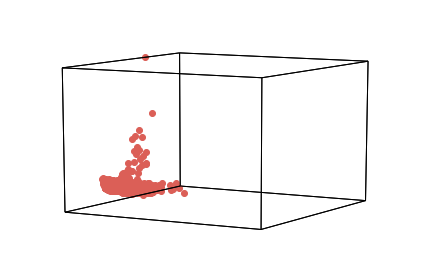

In [0]:
hyp.plot(train_x,'o')

/usr/local/lib/python3.6/dist-packages/hypertools/plot/plot.py:221: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/hypertools/plot/plot.py:312: UserWarning: n_clusters overrides hue, ignoring hue.
  warnings.warn('n_clusters overrides hue, ignoring hue.')
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32593 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22260 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/loca

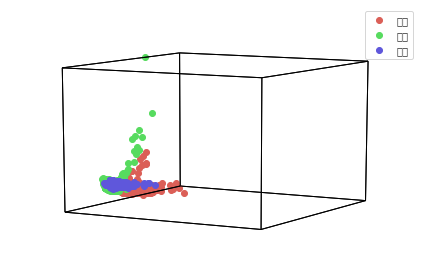

In [0]:
hyp.plot(train_x,'o', group=train_y, legend=list(set(train_y)),n_clusters=3)

In [0]:
from sklearn.feature_selection import RFECV

In [0]:
estimator = lgb.LGBMClassifier(objective = 'multi:softmax',
                         n_estimators=500,
                         max_depth = 7,
                         num_leaves = 43,
                         learning_rate = 0.318,
                         feature_fraction = 0.5,
                         min_child_samples=12,
                         min_child_weight=0.0016,
                         bagging_fraction = 0.901,
                         bagging_freq = 5,
                         reg_alpha = 0.0005,
                         reg_lambda = 0,
                         cat_smooth = 0,
                        )

In [0]:
selector = RFECV(estimator, 30,scoring='f1_macro',cv=5,verbose=300)

In [0]:
selector.fit(train_x,train_y)

Fitting estimator with 382 features.
Fitting estimator with 352 features.
Fitting estimator with 322 features.
Fitting estimator with 292 features.
Fitting estimator with 262 features.
Fitting estimator with 232 features.
Fitting estimator with 202 features.
Fitting estimator with 172 features.
Fitting estimator with 142 features.
Fitting estimator with 112 features.
Fitting estimator with 82 features.
Fitting estimator with 52 features.
Fitting estimator with 22 features.
Fitting estimator with 382 features.
Fitting estimator with 352 features.
Fitting estimator with 322 features.
Fitting estimator with 292 features.
Fitting estimator with 262 features.
Fitting estimator with 232 features.
Fitting estimator with 202 features.
Fitting estimator with 172 features.
Fitting estimator with 142 features.
Fitting estimator with 112 features.
Fitting estimator with 82 features.
Fitting estimator with 52 features.
Fitting estimator with 22 features.
Fitting estimator with 382 features.
Fitting

KeyboardInterrupt: ignored

In [0]:
train_x.columns[selector.support_]

AttributeError: ignored

In [0]:
len(train_x)

6963

In [0]:
train_x = train_x[['x_min', 'x_std', 'y_min', 'y_max', '速度_std', 'velocity_var_mean',
       'velocity_var_skew', 'angle_var_boxing', 'time_convert_var_mean',
       'velocity_c_rate_kurt', 'angle_c_rate_max', 'computed_angle_min',
       'computed_angle_max', 'computed_angle_mean', 'bearing_min',
       'bearing_max', 'bearing_mean', 'x_quantile_0.25', 'y_quantile_0.75',
       'xy_cov','max_area']]

In [0]:
test_x = test_x[['x_min', 'x_std', 'y_min', 'y_max', '速度_std', 'velocity_var_mean',
       'velocity_var_skew', 'angle_var_boxing', 'time_convert_var_mean',
       'velocity_c_rate_kurt', 'angle_c_rate_max', 'computed_angle_min',
       'computed_angle_max', 'computed_angle_mean', 'bearing_min',
       'bearing_max', 'bearing_mean', 'x_quantile_0.25', 'y_quantile_0.75',
       'xy_cov','max_area']]

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
#尝试lightgbm
import lightgbm as lgb

In [0]:
#0.8847

In [0]:
parameters = {   
    'min_child_weight': [0.0016]
     
}
gbm = lgb.LGBMClassifier(objective = 'multi:softmax',
                         n_estimators=380,
                         max_depth = 7,
                         num_leaves = 36,
                         learning_rate = 0.322,
                         feature_fraction = 1,
                         min_child_samples=12,
                         min_child_weight=0.0016,
                         bagging_fraction = 0.901,
                         bagging_freq = 0,
                         reg_alpha = 0.00187,
                         reg_lambda = 0,
                         cat_smooth = 0,
                        )
gsearch = GridSearchCV(estimator=gbm, param_grid=parameters, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
gsearch.fit(train_x, train_y)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


参数的最佳取值:{'min_child_weight': 0.0016}
最佳模型得分:0.8882668072853235
[0.88826681]
[{'min_child_weight': 0.0016}]


In [0]:
len(train_x.columns)

28

In [0]:
lgb1 = lgb.LGBMClassifier(objective = 'multi:softmax',
                         n_estimators=380,
                         max_depth = 7,
                         num_leaves = 36,
                         learning_rate = 0.322,
                         feature_fraction = 1,
                         min_child_samples=12,
                         min_child_weight=0.0016,
                         bagging_fraction = 0.901,
                         bagging_freq = 0,
                         reg_alpha = 0.00187,
                         reg_lambda = 0,
                         cat_smooth = 0,
                        )


In [0]:
lgb1.fit(train_x,train_y)

LGBMClassifier(bagging_fraction=0.901, bagging_freq=0, boosting_type='gbdt',
               cat_smooth=0, class_weight=None, colsample_bytree=1.0,
               feature_fraction=1, importance_type='split', learning_rate=0.322,
               max_depth=7, min_child_samples=12, min_child_weight=0.0016,
               min_split_gain=0.0, n_estimators=380, n_jobs=-1, num_leaves=36,
               objective='multi:softmax', random_state=None, reg_alpha=0.00187,
               reg_lambda=0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
list(train_x.columns)

['x_min',
 'x_max',
 'y_min',
 'y_max',
 '速度_std',
 '速度_covar',
 'y_var_std',
 'velocity_var_mean',
 'velocity_var_skew',
 'angle_var_mean',
 'time_convert_var_rms',
 'angle_c_rate_max',
 'computed_angle_min',
 'computed_angle_max',
 'computed_angle_mean',
 'computed_angle_c_rate_covar',
 'haversine_max',
 'dummy_manhattan_distance_fengzhi',
 'bearing_min',
 'bearing_max',
 'bearing_mean',
 'x_quantile_0.1',
 'y_quantile_0.58',
 'angle_var_quantile_0.74',
 'angle_var_quantile_0.9',
 'time_convert_var_quantile_0.9',
 'xy_cov',
 'velocity_second_counts']

In [0]:
lgb1.feature_importances_

array([ 826,  828,  898, 1087,  888,  830,  809,  844,  821,  805,  767,
        811,  826, 1113,  879,  862,  777,  840, 1132, 1047,  971, 1127,
       1058,  925,  865,  803,  911,  691])

In [0]:
len(train_x.columns[lgb1.feature_importances_>800])

25

In [0]:
train_x = train_x[train_x.columns[lgb1.feature_importances_>800]]

In [0]:
len(train_x.columns)

25

In [0]:
from xgboost import XGBClassifier

In [0]:
cv_params = {'learning_rate': [0.3]}
regress_model = XGBClassifier(learning_rate=0.3, n_estimators= 900, gamma= 0, max_depth= 4, min_child_weight= 1,
                colsample_bytree= 0.66, colsample_bylevel= 1, subsample= 1, reg_lambda= 1.2, reg_alpha= 0,
                seed= 33)  
gs = GridSearchCV(estimator=regress_model, param_grid= cv_params, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
gs.fit(train_x, train_y)  
# 性能测评
print("参数的最佳取值：:", gs.best_params_)
print("最佳模型得分:", gs.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.3s finished


参数的最佳取值：: {'learning_rate': 0.3}
最佳模型得分: 0.8839186901802969


In [0]:
xgb1 = XGBClassifier(learning_rate=0.3, n_estimators= 900, gamma= 0, max_depth= 4, min_child_weight= 1,
                colsample_bytree= 0.66, colsample_bylevel= 1, subsample= 1, reg_lambda= 1.2, reg_alpha= 0,
                seed= 33) 

In [0]:
xgb1.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.66, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=33,
              silent=None, subsample=1, verbosity=1)

In [0]:
train_x.columns[:10]

Index(['x_min', 'x_max', 'x_mean', 'x_std', 'x_skew', 'x_kurt', 'x_range',
       'x_covar', 'x_abs_energy', 'x_absolute_sum_of_changes'],
      dtype='object')

In [0]:
xgb1.feature_importances_

array([0.16701941, 0.07163686, 0.0821036 , 0.08572276, 0.09237728,
       0.02533929, 0.0467567 , 0.04132583, 0.02747926, 0.02379329,
       0.06916301, 0.19580272, 0.03398553, 0.03749449], dtype=float32)

In [0]:
train_x.columns[lgb1.feature_importances_>100]

Index(['x_min', 'x_max', 'x_mean', 'x_c3', 'x_partial_autocorrelation',
       'y_min', 'y_max', 'y_mean', '速度_partial_autocorrelation',
       '方向_partial_autocorrelation', 'y_var_partial_autocorrelation',
       'velocity_var_agg_autocorrelation_mean',
       'time_convert_var_longest_strike_below_mean',
       'time_convert_var_percentage_of_reoccurring_datapoints_to_all_datapoints',
       'angle_c_rate_percentage_of_reoccurring_values_to_all_values',
       'computed_angle_max', 'computed_angle_c_rate_covar', 'bearing_min',
       'bearing_max', 'x_quantile_0.25', 'x_quantile_0.75', 'y_quantile_0.25',
       'y_quantile_0.75', 'velocity_second_counts', 'velocity_third_counts'],
      dtype='object')

In [0]:
train_x.columns[lgb1.feature_importances_>1100]

Index(['x_min', 'x_max', 'y_min', 'y_max', 'angle_var_kurt',
       'time_convert_var_mean', 'computed_angle_max', 'computed_angle_mean',
       'bearing_min', 'bearing_mean', 'x_quantile_0.25', 'y_quantile_0.75',
       'xy_cov'],
      dtype='object')

In [0]:
train_x.columns

Index(['x_min', 'x_max', 'x_kurt', 'y_min', 'y_max', 'y_skew',
       'velocity_var_mean', 'velocity_var_skew', 'velocity_var_covar',
       'angle_var_kurt', 'time_convert_var_mean', 'velocity_c_rate_skew',
       'computed_angle_min', 'computed_angle_max', 'computed_angle_mean',
       'computed_angle_c_rate_covar', 'bearing_min', 'bearing_max',
       'bearing_mean', 'bearing_skew', 'x_quantile_0.25', 'x_quantile_0.75',
       'y_quantile_0.25', 'y_quantile_0.75', 'xy_cov',
       'velocity_second_counts', 'db_cluster'],
      dtype='object')

In [0]:
xgb1.predict(train_x)[:20] #对应回去观察 第三列拖网 第二列围网 第一列 刺网

array(['拖网', '拖网', '围网', '刺网', '拖网', '拖网', '围网', '拖网', '拖网', '围网', '拖网',
       '拖网', '拖网', '拖网', '拖网', '拖网', '围网', '围网', '拖网', '拖网'], dtype=object)

In [0]:
def class_dec(x):
  if(x[0]):
    return '刺网'
  if(x[1]):
    return '围网'
  if(x[2]):
    return '拖网'

In [0]:
len(train_x)

6963

In [0]:
train_x

NameError: ignored

In [0]:
test_x = test_x[['x_min', 'x_max', 'y_min', 'y_max', 'angle_var_kurt',
       'time_convert_var_mean', 'computed_angle_max', 'computed_angle_mean',
       'bearing_min', 'bearing_mean', 'x_quantile_0.25', 'y_quantile_0.75',
       'xy_cov','db_cluster']]
      

In [0]:
result = pd.DataFrame(pd.DataFrame(((lgb1.predict_proba(test_x) + xgb1.predict_proba(test_x))/2)>(1/3)).apply(class_dec,axis=1))

In [0]:
result.index = test_x.index

In [0]:
result.iloc[:,0].value_counts()

拖网    1244
围网     483
刺网     273
Name: 0, dtype: int64

In [0]:
result.iloc[:,0].value_counts()[0]/len(result)

0.622

In [0]:
result.iloc[:,0].value_counts()[1]/len(result)

0.2415

In [0]:
result.iloc[:,0].value_counts()[2]/len(result)

0.1365

In [0]:
result.to_csv('drive2/Colab Notebooks/result9.csv',header=None,encoding='utf-8')